# Prediction model

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

## Import data
Might still need to clean up the files some after import

In [2]:
path = '../Clean Data'
X_fn = 'X.csv'
y_fn = 'y.csv'
X_path = os.path.join(path, X_fn)
y_path = os.path.join(path, y_fn)

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [3]:
X.head()

,Unnamed: 0,cluster_id_6,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),Month,NG Price ($/mcf),All coal,Lignite,Subbituminous
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,1,6.42,25.1475,20.0275,28.115
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,1,6.42,25.1475,20.0275,28.115
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,1,6.42,25.1475,20.0275,28.115
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,1,6.42,25.1475,20.0275,28.115
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,1,6.42,25.1475,20.0275,28.115


Rename the cluster column to just `cluster`. This won't be needed once we export from the group classification with the correct column name

In [4]:
X.rename(columns={'cluster_id_6':'cluster'}, inplace=True)

### Ratio of prices
Divide coal prices by natural gas price, drop natural gas price

In [5]:
for fuel in ['All coal', 'Lignite', 'Subbituminous']:
    X.loc[:,fuel] = X.loc[:,fuel].values/X.loc[:,'NG Price ($/mcf)'].values
    
X.drop('NG Price ($/mcf)', axis=1, inplace=True)

### One-hot encoding of the cluster variable
I'm trying to make this easy for using with different numbers of clusters

In [6]:
cluster_ids = X['cluster'].unique()
for cluster in cluster_ids:
    X['cluster_{}'.format(cluster)] = np.eye(len(cluster_ids))[X['cluster'],cluster]

In [7]:
X.head()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,Month,All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,...,1,3.917056,3.119548,4.379283,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,...,1,3.917056,3.119548,4.379283,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,...,1,3.917056,3.119548,4.379283,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,...,1,3.917056,3.119548,4.379283,1.0,0.0,0.0,0.0,0.0,0.0
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,...,1,3.917056,3.119548,4.379283,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X.tail()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,Month,All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
473329,473329,5,2015,11476.0,2015-12-31 19:00:00,7516.0,39908.77734,16170.0,3824.932373,23.654498,...,12,12.793722,10.780269,14.596413,0.0,0.0,0.0,0.0,0.0,1.0
473330,473330,5,2015,11476.0,2015-12-31 20:00:00,6552.0,38736.85938,16170.0,4625.632813,28.606264,...,12,12.793722,10.780269,14.596413,0.0,0.0,0.0,0.0,0.0,1.0
473331,473331,5,2015,11476.0,2015-12-31 21:00:00,5944.0,37587.70313,16170.0,4957.714844,30.659956,...,12,12.793722,10.780269,14.596413,0.0,0.0,0.0,0.0,0.0,1.0
473332,473332,5,2015,11476.0,2015-12-31 22:00:00,5698.0,36356.26172,16170.0,4699.097656,29.060592,...,12,12.793722,10.780269,14.596413,0.0,0.0,0.0,0.0,0.0,1.0
473333,473333,5,2015,11476.0,2015-12-31 23:00:00,5365.0,35150.33984,16170.0,4313.125000,26.673624,...,12,12.793722,10.780269,14.596413,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
y.tail()

,Unnamed: 0,DATETIME,cluster_id_6,Gen Change (MW)
473329,473329,2015-12-31 19:00:00,5,-20.0
473330,473330,2015-12-31 20:00:00,5,-964.0
473331,473331,2015-12-31 21:00:00,5,-608.0
473332,473332,2015-12-31 22:00:00,5,-246.0
473333,473333,2015-12-31 23:00:00,5,-333.0


### Drop unnecessary columns and replace nan's with 0

In [10]:
X_cols = ['nameplate_capacity', 'GROSS LOAD (MW)', 'ERCOT Load, MW',
          'Total Wind Installed, MW', 'Total Wind Output, MW', 'Net Load Change (MW)',
          'NG Price ($/mcf)', 'All coal', 'Lignite', 'Subbituminous']
X_cluster_cols = ['cluster_{}'.format(cluster) for cluster in cluster_ids]

X_clean = X.loc[:,X_cols+X_cluster_cols]
X_clean.fillna(0, inplace=True)

y_clean = y.loc[:,'Gen Change (MW)']
y_clean.fillna(0, inplace=True)

In [11]:
print X_clean.shape
print y_clean.shape

(473334, 16)
(473334L,)


### Split into training, validation, testing

In [12]:
X_train = X_clean.loc[(X['Year']<2012),:]
y_train = y_clean.loc[(X['Year']<2012)]

X_va = X_clean.loc[X['Year'].isin([2012, 2013]),:]
y_va = y_clean.loc[X['Year'].isin([2012, 2013])]

X_test = X_clean.loc[X['Year']>2013,:]
y_test = y_clean.loc[X['Year']>2013]

**Somehow we're missing 2 records from X_va**

In [13]:
print X_va.shape, y_va.shape

(105264, 16) (105264L,)


Need scaled versions of the X data for some of the models

In [14]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_va_scaled = StandardScaler().fit_transform(X_va)
X_test_scaled = StandardScaler().fit_transform(X_test)

Check size of all arrays

In [15]:
print X_train_scaled.shape, y_train.shape
print X_va_scaled.shape, y_va.shape
print X_test_scaled.shape, y_test.shape

(262944L, 16L) (262944L,)
(105264L, 16L) (105264L,)
(105126L, 16L) (105126L,)


## Linear Regression (OLS)

In [16]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
lm.score(X_va_scaled, y_va)

0.26678101097937934

In [18]:
y_pr = lm.predict(X_va_scaled)

In [19]:
y_va.values.shape, y_pr.shape, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values.shape

((105264L,), (105264L,), (105264L,))

In [20]:
y_lm_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))
# y_lm_resids['y_pr'] = y_pr
# y_lm_resids['cluster'] = X.loc[:,'cluster']

In [21]:
y_lm_resids.head()

,Gen Change (MW),cluster,y_pr
0,0.0,0,-56.223127
1,1.0,0,-15.262189
2,-1.0,0,-12.223127
3,0.0,0,-9.316877
4,0.0,0,25.909686


In [22]:
y_lm_resids.loc[:,'residuals'] = y_lm_resids.loc[:,'y_pr'] - y_lm_resids.loc[:,'Gen Change (MW)']

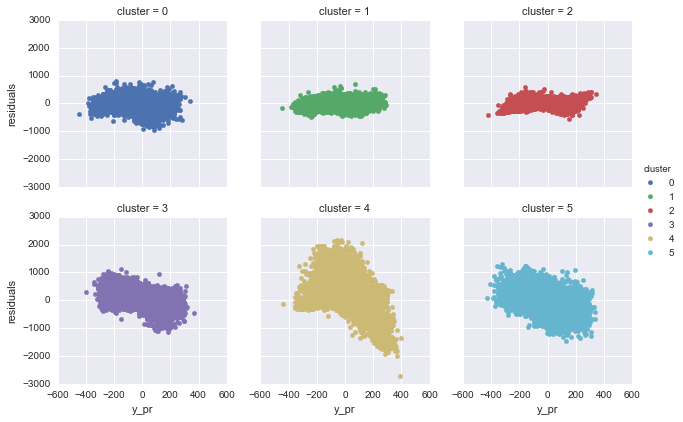

In [23]:
g = sns.FacetGrid(y_lm_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'y_pr', 'residuals')
g.add_legend()

## LinearSVR
The rbf kernal of SVR is very slow with this large of a dataset. If we want to try using it, should probably subsample.

Shows use with GridSearchCV if you guys want to use it

In [24]:
svm = LinearSVR()

In [25]:
parameters = {'C':np.logspace(-5, 3, num=15)}

In [26]:
lm = GridSearchCV(svm, parameters, n_jobs=-1, verbose=3)

Run the LinearSVR with gridsearch over the 15 parameter values. GridSearchCV does 3-fold CV by default.

In [27]:
results = lm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


#### Validation Curve

In [42]:


param_range = np.logspace(-5, 3, num=15)
train_scores, valid_scores = validation_curve(LinearSVR(), X_train_scaled, y_train, "C", param_range)

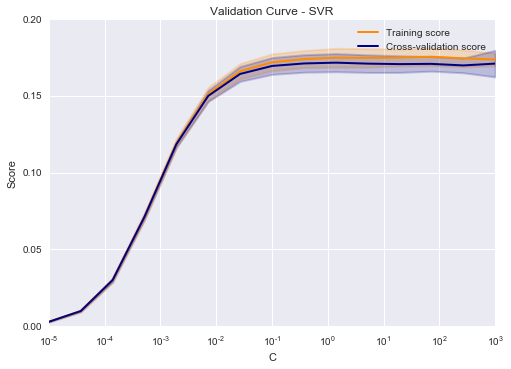

In [49]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve - SVR")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, .2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#### Learning Curve

<function matplotlib.pyplot.show>

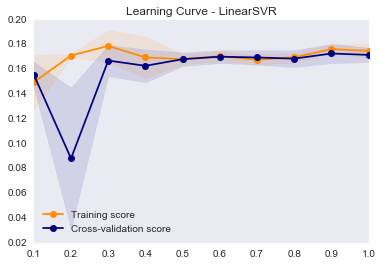

In [67]:
xLen = len(X_train_scaled)
tSize = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
train_sizes, train_scores, valid_scores = learning_curve(LinearSVR(), X_train_scaled, y_train, train_sizes = tSize)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.grid()

plt.title("Learning Curve - LinearSVR")
plt.fill_between(tSize, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange")
plt.fill_between(tSize, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="navy")
plt.plot(tSize, train_scores_mean, 'o-', color="darkorange",
         label="Training score")
plt.plot(tSize, valid_scores_mean, 'o-', color="navy",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show

`cv_results_` returns a dictionary with all of the results and parameters

In [28]:
results.cv_results_

{'mean_fit_time': array([  0.29466669,   0.31133342,   0.53800003,   0.65266665,
          0.80899994,   0.78433331,   0.81199996,   0.87266668,
          0.9866666 ,   1.28399992,   2.15866669,   4.79399999,
         11.95500008,  25.98933331,  43.23566675]),
 'mean_score_time': array([ 0.03633332,  0.03933334,  0.08633327,  0.01066677,  0.0126667 ,
         0.00999999,  0.01366663,  0.01433341,  0.01833336,  0.01333332,
         0.01299993,  0.01333332,  0.01366663,  0.01099992,  0.00766659]),
 'mean_test_score': array([ 0.00287043,  0.00987067,  0.03003211,  0.07128326,  0.11854968,
         0.1501322 ,  0.1644035 ,  0.16960687,  0.17144693,  0.17192847,
         0.17160952,  0.17128199,  0.17042826,  0.17088725,  0.16581553]),
 'mean_train_score': array([ 0.00287357,  0.00988178,  0.03007964,  0.07148156,  0.11913756,
         0.1513134 ,  0.16617615,  0.17197534,  0.17427679,  0.17499071,
         0.17536349,  0.17557742,  0.17513131,  0.17544765,  0.17128382]),
 'param_C': masked

In [29]:
test_score = results.cv_results_['mean_test_score']
train_score = results.cv_results_['mean_train_score']

In [30]:
C = [results.cv_results_['params'][x]['C'] for x in range(15)]

In [31]:
C

[1.0000000000000001e-05,
 3.7275937203149381e-05,
 0.00013894954943731373,
 0.0005179474679231213,
 0.0019306977288832496,
 0.0071968567300115137,
 0.026826957952797246,
 0.10000000000000001,
 0.37275937203149379,
 1.3894954943731359,
 5.1794746792312019,
 19.306977288832496,
 71.96856730011514,
 268.26957952797216,
 1000.0]

Plot the score for each value of C

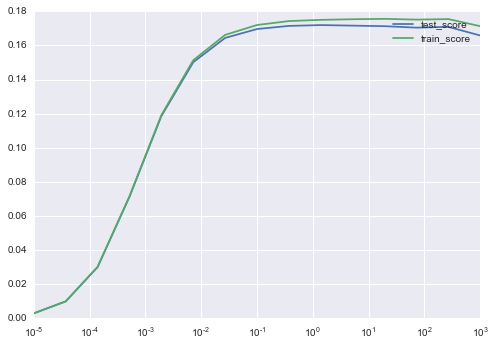

In [32]:
plt.semilogx(C, test_score, C, train_score)
plt.legend(['test_score', 'train_score'])

## SVR with rbf
Try subsampling?

In [33]:
X_train_scaled.shape

(262944L, 16L)

In [38]:
idx = np.random.choice(np.arange(len(X_train_scaled)), size=int(len(X_train_scaled)*0.5), replace=False)

In [39]:
lm = SVR()

In [40]:
lm.fit(X_train_scaled[idx], y_train[idx])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
lm.score(X_va_scaled, y_va)

0.28122217024273011

### Learning Curve

[learning_curve] Training set sizes: [17529 35059 52588 70118 87648]


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  7.0min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 20.1min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 42.0min finished


<function matplotlib.pyplot.show>

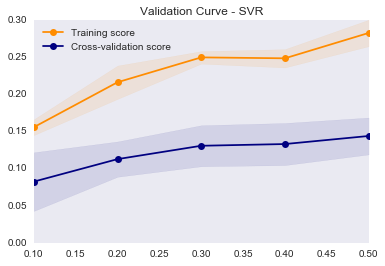

In [69]:
xLen = len(X_train_scaled)
tSize = [.1, .2, .3, .4, .5]
train_sizes, train_scores, valid_scores = learning_curve(SVR(), X_train_scaled, y_train, train_sizes = tSize, n_jobs = -1, verbose = 3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.grid()

plt.title("Validation Curve - SVR")
plt.fill_between(tSize, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange")
plt.fill_between(tSize, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="navy")
plt.plot(tSize, train_scores_mean, 'o-', color="darkorange",
         label="Training score")
plt.plot(tSize, valid_scores_mean, 'o-', color="navy",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show